# Example of parameters optimization with SpikeInterface

This notebook is an example of parameters optimization with SpikeInterface.
See also this [notebook on ground-truth comparison](https://spikeinterface.github.io/blog/example-of-ground-truth-comparison-study) that analyzes the same dataset.

The dataset is simulated using [MEArec](https://github.com/alejoe91/MEArec) and it can be downloaded from Zenodo: https://doi.org/10.5281/zenodo.4058272

The dataset name is: **recordings_50cells_SqMEA-10-15_600.0_10.0uV_21-01-2020_18-12.h5**. It contains 50 neurons recorded on a 10x10 MEA with 15um pitch. The duration is 600s and the noise level is 10uV.

Many sorters a parameters of **adjacency radius** that help the sorter to group spike that have a peak on several channel.

  * ironlcust uses **adjacency_radius=50** by default
  * spykingcircus uses **adjacency_radius=200** by default
  * herdingspikes uses **probe_neighbor_radius=90** by default

Since each channel is spaced by 15um in this dataset, the radius parameters can affect the way each sorter detects and sorts spikes that are recorded on several channels.

Author: [Samuel Garcia](https://github.com/samuelgarcia), CRNL, Lyon

### Requirements

For this need you will need the following Python packages:

- numpy
- pandas
- matplotlib
- seaborn
- spikeinterface

To run the MATLAB-based sorters, you would also need a MATLAB license.
For other sorters, please refer to the documentation on [how to install sorters](https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html).

### Installation and imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.comparison as sc

In [ ]:
# clone and install MATLAB sorters

# ironclust
!git clone https://github.com/flatironinstitute/ironclust.git
ironclust_path = './ironclust'
ss.IronclustSorter.set_ironclust_path(ironclust_path)

## Check spikeinterface version and sorter version

In order to be a bit reproducible lets checks for versions of each sorter and spikeinterface subpackage.

In [3]:
si.print_spikeinterface_version()
ss.print_sorter_version()

spikeinterface: 0.9.1
  * spikeextractor: 0.7.1
  * spiketoolkit: 0.5.1
  * spikesorters: 0.2.2
  * spikecomparison: 0.2.2
  * spikewidgets: 0.3.2

herdingspikes: 0.3.3+git.f5232ac3520d
klusta: 3.0.16
mountainsort4: unknown
spykingcircus: 0.9.0
tridesclous: 1.4.2


## Setup global path

In [12]:
# Change this path to point to where you downloaded the dataset
p = Path('/home/samuel/Documents/DataSpikeSorting/mearec/')
study_folder = p / 'study_mearec_SqMEA1015um/'
param_folder = p / 'param_search'

mearec_filename = p / 'recordings_50cells_SqMEA-10-15_600.0_10.0uV_21-01-2020_18-12.h5'

## Run sorters with differents parameters

Lets try several radius : 20, 50, 100, 150, 200

results are saved to files

In [13]:
sorter_names = ['ironclust', 'spykingcircus', 'herdingspikes']
radius_list = [20, 50, 100, 150, 200]

In [ ]:
rec  = se.MEArecRecordingExtractor(mearec_filename)

param_names = {
    'ironclust': 'adjacency_radius',
    'spykingcircus': 'adjacency_radius',
    'herdingspikes': 'probe_neighbor_radius',
}

for sorter_name in sorter_names:
    for radius in radius_list:
        params = {param_names[sorter_name] : radius}
        sorting = ss.run_sorter(sorter_name, rec,
                                    output_folder=param_folder / f'{sorter_name}_{radius}',
                                    delete_output_folder=True,
                                    **params)
        se.NpzSortingExtractor.write_sorting(sorting, param_folder / f'{sorter_name}_{radius}.npz')

## Retrieve results and compare to ground truth

In [14]:
study = sc.GroundTruthStudy(study_folder)
snr = study.get_units_snr()

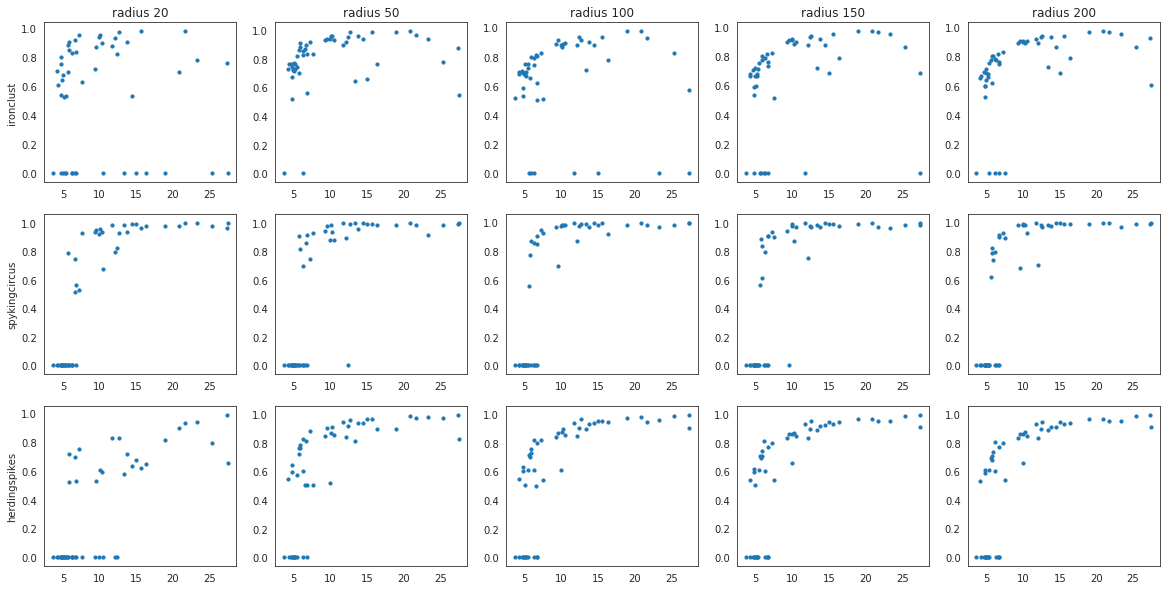

In [16]:
gt_sorting = se.MEArecSortingExtractor(mearec_filename)

fig, axs = plt.subplots(nrows=len(sorter_names), ncols=len(radius_list), figsize=(20,10))
for r, sorter_name in enumerate(sorter_names):
    for c, radius in enumerate(radius_list):
        sorting = se.NpzSortingExtractor(param_folder / f'{sorter_name}_{radius}.npz')
        comp = sc.compare_sorter_to_ground_truth(gt_sorting, sorting)
        perfs = comp.get_performance(method='by_unit')
        axs[r, c].scatter(snr['snr'], perfs['accuracy'], s=10)


        axs[0, c].set_title(f'radius {radius}')

    axs[r, 0].set_ylabel(sorter_name)

## Conclusion


In this preliminary example, we found that:

* spykingcircus is hardly affected by the adjacency radius parameter
* herdingspikes is only affected (worsened results) for very small radius (20um)
* ironclust tends to prefer higher radiuses as the best performance is achieved with 150-200um